# YoloV1

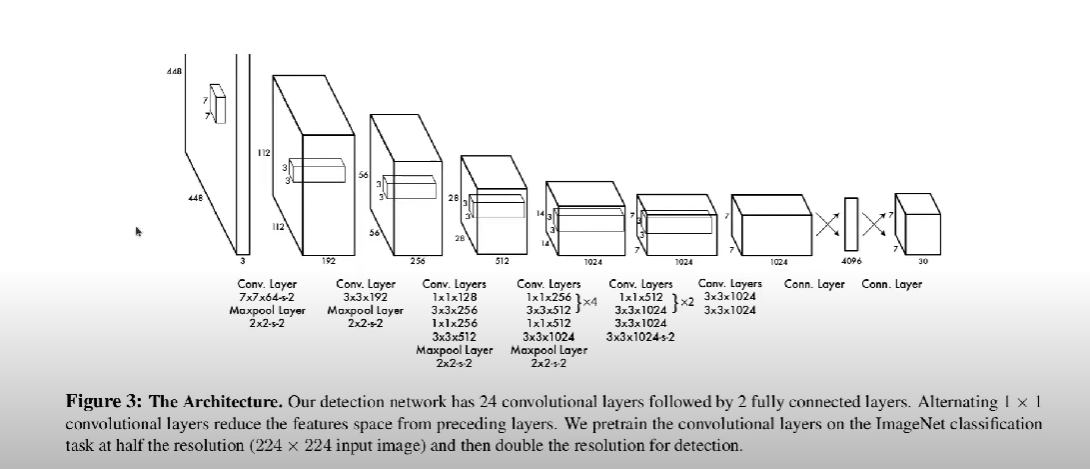

In [1]:
import torch 
from torch import nn
class CNNBlock(nn.Module):
    def __init__(self,in_channels,out_channels,**kwargs):
        super(CNNBlock,self).__init__()
        self.conv=nn.Conv2d(in_channels,out_channels=out_channels,bias=False,**kwargs)
        self.batchnorm=nn.BatchNorm2d(out_channels)
        self.leakyrelu=nn.LeakyReLU(0.1)

    def forward(self,x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))
    


architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [2]:
class Yolov1(nn.Module):
    def __init__(self,in_channels=3,**kwargs):
        super(Yolov1,self).__init__()

        self.architecture =architecture_config
        self.in_channels=in_channels
        self.darknet=self._create_conv_layers(self.architecture)
        self.fcs=self._create_fcs(**kwargs)

    def forward(self,x):
        x=self.darknet(x)
        return self.fcs(torch.flatten(x,start_dim=1))
    

    def _create_fcs(self,split_size,num_boxes,num_classes):
        S,B,C =split_size,num_boxes,num_classes
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*S*S,496), # In original paper this should be 4096
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.Linear(496,S * S * (C+B*5))

        )



    def _create_conv_layers(self,architecture):
        layers=[]
        in_channels=self.in_channels
        for x in architecture:
            if type(x)==tuple:
                layers+=[CNNBlock(
                    in_channels=in_channels,out_channels=x[1],kernel_size=x[0],stride=x[2],padding=x[3]
                    )
                ]

                in_channels = x[1]
            elif type(x)==str:
                layers+=[nn.MaxPool2d(kernel_size=2,stride=2)]

            elif type(x)==list:
                conv1=x[0]
                conv2=x[1]
                num_repeats=x[2]

                for _ in range(num_repeats):
                    layers+=[
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3]
                        )
                    ]

                    layers+=[CNNBlock(
                        conv1[1],
                        conv2[1],
                        kernel_size=conv2[0],
                        stride=conv2[2],
                        padding=conv2[3]
                    )]

                    in_channels=conv2[1]

        return nn.Sequential(*layers)
    
def test(S=7,B=2,C=20):
    model=Yolov1(split_size=S,num_boxes=B,num_classes=C)
    x=torch.randn((2,3,448,448))
    print(model(x).shape)


#30 mins


In [8]:
import torch


def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct Labels of Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    # Slicing idx:idx+1 in order to keep tensor dimensionality
    # Doing ... in indexing if there would be additional dimensions
    # Like for Yolo algorithm which would have (N, S, S, 4) in shape
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # Need clamp(0) in case they do not intersect, then we want intersection to be 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [9]:
# test()
x=torch.randn((2,3,448,448))
model=Yolov1(split_size=7,num_boxes=2,num_classes=20)
pred=model.forward(x)

In [10]:
pred.shape

torch.Size([2, 1470])

In [11]:
targets=torch.randn(2,7,7,25)

In [12]:
S=7
B=2
C=20
predictions=pred.reshape(-1,S,S,C+B*5)

In [13]:
iou_b1=intersection_over_union(predictions[...,21:25],targets[...,21:25])
iou_b2=intersection_over_union(predictions[...,26:30],targets[...,21:25])

In [14]:
iou_b1.shape

torch.Size([2, 7, 7, 1])

In [15]:
iou_b1.unsqueeze(0).shape

torch.Size([1, 2, 7, 7, 1])

In [16]:
ious=torch.cat([iou_b1.unsqueeze(0),iou_b2.unsqueeze(0)],dim=0)

In [17]:
ious_maxes,bestbox=torch.max(ious,dim=0)
exists_box=targets[...,20].unsqueeze(3)

In [18]:
exists_box.shape

torch.Size([2, 7, 7, 1])

In [19]:
print(bestbox.shape)
print(ious_maxes.shape)

torch.Size([2, 7, 7, 1])
torch.Size([2, 7, 7, 1])


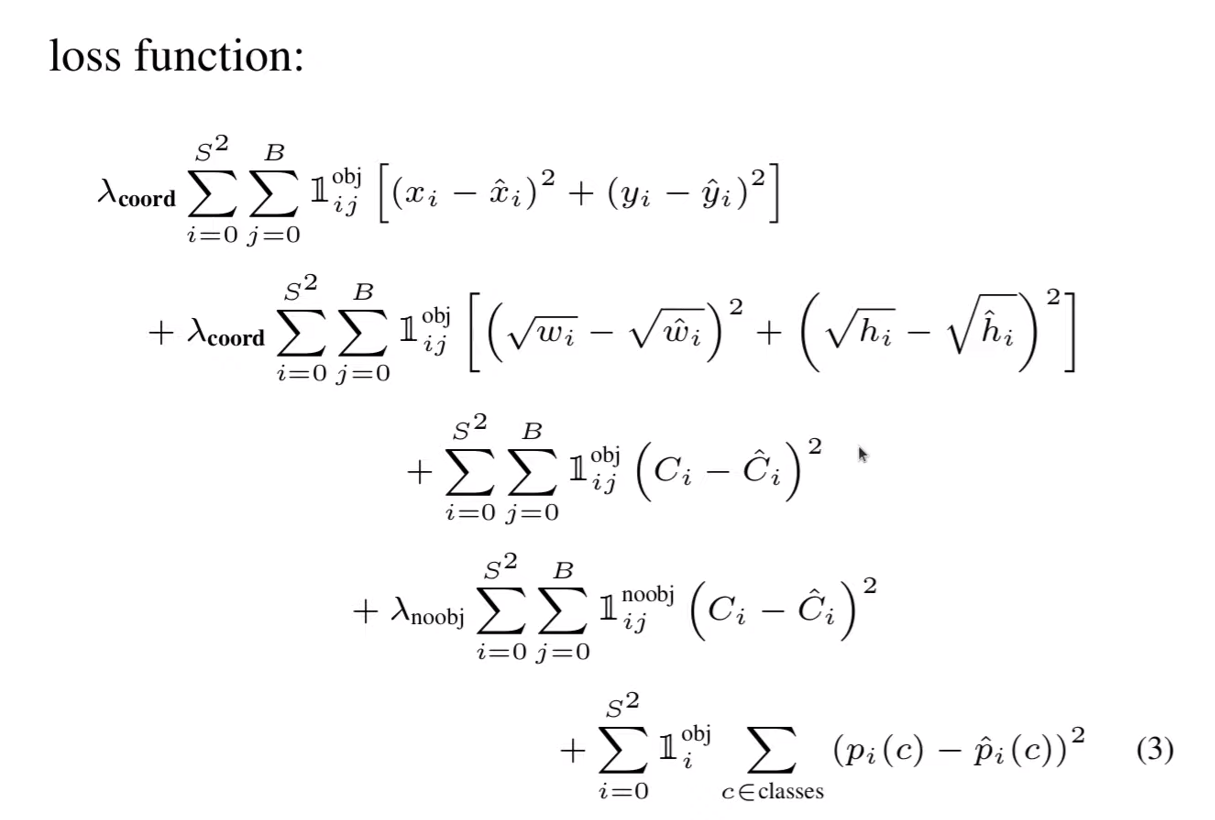

In [21]:
import torch 
from torch import nn
# from utils import itersection_over_union

class YoloLoss(nn.Module):
    def __init__(self,S=7,B=2,C=20):
        super(YoloLoss,self).__init__()
        self.mse=nn.MSELoss(reduction="sum")
        self.S=S
        self.B=B
        self.C=C
        self.lambda_noobj=0.5
        self.lambda_coord=5
        
    def forward(self,predictions,targets):
        predictions=predictions.reshape(-1,self.S,self.S,self.C+self.B*5)
        iou_b1=intersection_over_union(predictions[...,21:25],targets[...,21:25])
        iou_b2=intersection_over_union(predictions[...,26:30],targets[...,21:25])
        ious=torch.cat([iou_b1.unsqueeze(0),iou_b2.unsqueeze(0)],dim=0)
        ious_maxes,bestbox=torch.max(ious,dim=0)
        exists_box=targets[...,20].unsqueeze(3)

        # For Box Coordinates loss
        box_predictions=exists_box * (
            (
                bestbox * predictions[...,26:30]
                + (1-bestbox) * predictions[...,21:25]
            )
        )

        box_targets=exists_box * targets[...,21:25]

        box_predictions[...,2:4]=torch.sign(box_predictions[...,2:4]) * torch.sqrt(
            torch.abs(box_predictions[...,2:4] + 1e-6)
        )

        box_targets[...,2:4]=torch.sqrt(box_targets[...,2:4])

        # (N,S,S,4) - > (N*S*S,4)
        box_loss=self.mse(
            torch.flatten(box_predictions,end_dim=-2),
            torch.flatten(box_targets,end_dim=-2)

        )

        # For Object Loss
        pred_box=(
            bestbox * predictions[...,25:26] + (1-bestbox) * predictions[...,20:21]
        )
        object_loss=self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * targets[...,20:21])
        )


        # For No Object Loss
        no_object_loss=self .mse(
            torch.flatten((1-exists_box) * predictions[...,25:26],start_dim=1),
            torch.flatten((1-exists_box) * targets[...,20:21],start_dim=1)

        )

        # For Class Loss
        class_loss=self.mse(
            torch.flatten(exists_box * predictions[...,:20],end_dim=-2),
            torch.flatten(exists_box * targets[...,:20],end_dim=-2)
        )


        loss=(self.lambda_coord * box_loss 
        + object_loss 
        + self.lambda_noobj * no_object_loss 
        + class_loss)

        
        















## Dataset

In [ ]:
import torch
import os
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader,Dataset

class VOCDataset(Dataset):
    def __init__(self,csv_file,img_dir,label_dir,S=7,B=2,C=20,transform=None):
        self.annotations=pd.read_csv(csv_file)
        self.img_dir=img_dir
        self.label_dir=label_dir
        self.transform=transform
        self.S=S
        self.B=B
        self.C=C


    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):
        label_path=os.path.join(self.label_dir,self.annotations.iloc[index,1])
        boxes=[]
        with open(label_path) as f:
            for label in f.readlines():
                class_label,x,y,width,height=[float(x) if float(x) !=int(float(x)) else int(x)
                                              for x in label.replace("\n","").split()]
                
                boxes.append([class_label,x,y,width,height])

        img_path=os.path.join(self.img_dir,self.annotations.iloc[index,0])
        image=Image.open(img_path)
        boxes=torch.tensor(boxes)

        if self.transform:
            image,boxes=self.transform(image,boxes)

        label_matrix=torch.zeros((self.S,self.S,self.C +5 ))
        for box in boxes:
            class_label,xy,width,height=box.tolist()
            class_label=int(class_label)
            i,j = int(self.S * y), int(self.S * x)
            x_cell,y_cell =self.S * x -j , self.S * y -i 
            width_cell,height_cell = (
                width * self.S,
                height * self.S
            )

        

